## Deep Learning - Lab 03

* Full name: Đinh Anh Huy
* Student ID: 18110103

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input

### Bài tập 1.
**Hãy tạo ra một block DoubleConvMaxpool gồm 2 lớp ConvMaxpool có số filters lần lượt là 16, 32 và một block DoubleFC có số hidden nodes lần lượt là 100, 50.**

In [2]:
class Linear(tf.keras.layers.Layer):
  def __init__(self, units=32):
    super(Linear, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(input_shape[-1], self.units),
        initializer=tf.random_normal_initializer,
        trainable=True
    )
    self.b = self.add_weight(
        shape=(self.units,),
        initializer=tf.random_normal_initializer,
        trainable=True
    )

  def call(self, inputs):
    return tf.matmul(inputs,self.w) + self.b

In [3]:
class DoubleFC(tf.keras.layers.Layer):
  def __init__(self, units_1=100, units_2=50, activation_1=None, activation_2=None):
    super().__init__()
    self.linear_1 = Linear(units_1)
    self.linear_2 = Linear(units_2)
    self.activation_1 = activation_1
    self.activation_2 = activation_2
    
  def call(self, inputs):
    # First FC Layer
    if self.activation_1 == None:
      result = self.linear_1(inputs)
    elif self.activation_1 == 'relu':
      result = tf.nn.relu(self.linear_1(inputs))
    elif self.activation_1 == 'sigmoid':
      result = tf.nn.sigmoid(self.linear_1(inputs))
    elif self.activation_1 == 'tanh':
      result = tf.nn.tanh(self.linear_1(inputs))
    
    # Second FC Layer
    if self.activation_2 == None:
      result = self.linear_2(result)
    elif self.activation_2 == 'relu':
      result = tf.nn.relu(self.linear_2(result))
    elif self.activation_2 == 'sigmoid':
      result = tf.nn.sigmoid(self.linear_2(result))
    elif self.activation_2 == 'tanh':
      result = tf.nn.tanh(self.linear_2(result))
    
    return result

In [4]:
class ConvMaxPoolBlock(tf.keras.layers.Layer):
  def __init__(self, n_filters=2, filter_size=(3,3), pool_size=(2,2), strides=(2,2), activation="relu"):
    super().__init__()
    self.filter_size = filter_size
    self.n_filters = n_filters
    self.pool_size = pool_size
    self.strides = strides
    self.activation = activation

  def build(self, input_shape):
    self.kernel = self.add_weight(
        name="kernel",
        shape=(self.filter_size[0], self.filter_size[1], input_shape[-1], self.n_filters),
        initializer=tf.random_normal_initializer,
        trainable=True
    )
    self.bias = self.add_weight(
        name="bias",
        shape=(1, self.n_filters),
        initializer=tf.random_normal_initializer,
        trainable=True
    )

  def call(self, inputs):
    conv = K.conv2d(
        x=inputs,
        kernel=self.kernel,
        padding="same"
    )
    conv = conv + self.bias

    if self.activation == 'relu':
      conv = tf.nn.relu(conv)
    elif self.activation == 'sigmoid':
      conv = tf.nn.sigmoid(conv)
    elif self.activation == 'tanh':
      conv = tf.nn.tanh(conv)

    maxpool = K.pool2d(
        x=conv,
        pool_size=self.pool_size,
        strides=self.strides,
        pool_mode="max"
    )

    return maxpool

In [5]:
class DoubleConvMaxpoolBlock(tf.keras.layers.Layer):
  def __init__(self, 
               n_filters_1=16, filter_size_1=(3,3), pool_size_1=(2,2), strides_1=(2,2), activation_1='relu', 
               n_filters_2=32, filter_size_2=(3,3), pool_size_2=(2,2), strides_2=(2,2), activation_2='relu'):
    super(DoubleConvMaxpoolBlock, self).__init__()
    self.ConvMaxPoolBlock_1 = ConvMaxPoolBlock(
        n_filters=n_filters_1,
        filter_size=filter_size_1,
        pool_size=pool_size_1,
        strides=strides_1,
        activation=activation_1
    )
    self.ConvMaxPoolBlock_2 = ConvMaxPoolBlock(
        n_filters=n_filters_2,
        filter_size=filter_size_2,
        pool_size=pool_size_2,
        strides=strides_2,
        activation=activation_2
    )
  
  def call(self, inputs):
    maxpool = self.ConvMaxPoolBlock_1(inputs)
    maxpool = self.ConvMaxPoolBlock_2(maxpool)
    return maxpool

### Bài tập 2.
**Tạo ra model, train, và test trên tập mnist như hình bên dưới:**
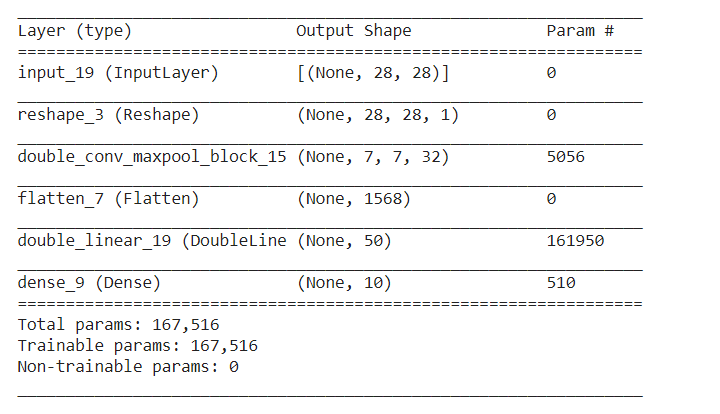

In [6]:
inputs = Input(shape=(28,28))

input_reshape = Reshape(target_shape=(28,28,1))(inputs)

double_conv_maxpool = DoubleConvMaxpoolBlock(
    n_filters_1=16,
    n_filters_2=32,
    filter_size_1=(5,5),
    filter_size_2=(3,3)
)(input_reshape)

flatten = Flatten()(double_conv_maxpool)

double_fc = DoubleFC(
    units_1=100,
    units_2=50,
    activation_1="relu",
    activation_2="relu"
)(flatten)

outputs = Dense(units=10, activation="softmax")(double_fc)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
double_conv_maxpool_block (D (None, 7, 7, 32)          5056      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
double_fc (DoubleFC)         (None, 50)                161950    
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 167,516
Trainable params: 167,516
Non-trainable params: 0
_______________________________________________________

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train, X_test = X_train/255.0, X_test/255.0

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

print("> Shape of training set  : ", X_train.shape)
print("> Shape of validation set: ", X_valid.shape)
print("> Shape of testing set   : ", X_test.shape)

> Shape of training set  :  (54000, 28, 28)
> Shape of validation set:  (6000, 28, 28)
> Shape of testing set   :  (10000, 28, 28)


In [8]:
# init Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-4/100)

# compile model
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

# fine-tune the model
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=50,
                    steps_per_epoch=X_train.shape[0]//128,
                    validation_data=(X_valid, y_valid))

Epoch 1/50
421/421 [==============================] - 4s 5ms/step - loss: 1.1569 - accuracy: 0.6595 - val_loss: 0.4201 - val_accuracy: 0.8742
Epoch 2/50
421/421 [==============================] - 2s 4ms/step - loss: 0.3190 - accuracy: 0.9070 - val_loss: 0.2649 - val_accuracy: 0.9185
Epoch 3/50
421/421 [==============================] - 2s 4ms/step - loss: 0.2170 - accuracy: 0.9372 - val_loss: 0.1940 - val_accuracy: 0.9422
Epoch 4/50
421/421 [==============================] - 2s 4ms/step - loss: 0.1618 - accuracy: 0.9518 - val_loss: 0.1527 - val_accuracy: 0.9567
Epoch 5/50
421/421 [==============================] - 2s 4ms/step - loss: 0.1295 - accuracy: 0.9618 - val_loss: 0.1296 - val_accuracy: 0.9618
Epoch 6/50
421/421 [==============================] - 2s 4ms/step - loss: 0.1070 - accuracy: 0.9681 - val_loss: 0.1098 - val_accuracy: 0.9672
Epoch 7/50
421/421 [==============================] - 2s 4ms/step - loss: 0.0941 - accuracy: 0.9718 - val_loss: 0.1014 - val_accuracy: 0.9715
Epoch 

In [9]:
evaluation = model.evaluate(X_test, y_test)
print("Accuracy of model on MNIST dataset: {}, and loss: {}.".format(evaluation[1], evaluation[0]))

313/313 [==============================] - 1s 2ms/step - loss: 0.0326 - accuracy: 0.9889
Accuracy of model on MNIST dataset: 0.9889000058174133, and loss: 0.03259352967143059.
